In [40]:
import pcDataLoader as pc
import pandas as pd
import os
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Loading simulation results

In [41]:
path = "../../../../output"
file = "/output00000000.xml"
path_file = path + file

In [42]:
phase_dict = {4: "G0G1_phase", 10: "S_phase", 11: "G2M_phase", 100: "apoptotic"}

In [43]:
xml_files = []

for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [44]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False);
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)



  0%|          | 0/481 [00:00<?, ?it/s]

In [45]:
def filter_duration(full_data, phase, ID):
    df = full_data[(full_data.phase == phase) & (full_data.ID == ID)]
    df2 = df.copy()

    for i in range(1, len(df["duration"])):
        index_prev = df["duration"].index[i - 1]
        index = df["duration"].index[i]
        if df["duration"][index] > df["duration"][index_prev]:
            df2.drop([index_prev], inplace=True)
    return df2

In [46]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/57 [00:00<?, ?it/s]

# Analysis of phases durations

AVERAGE DURATION OF EACH CELL CYCLE PHASE


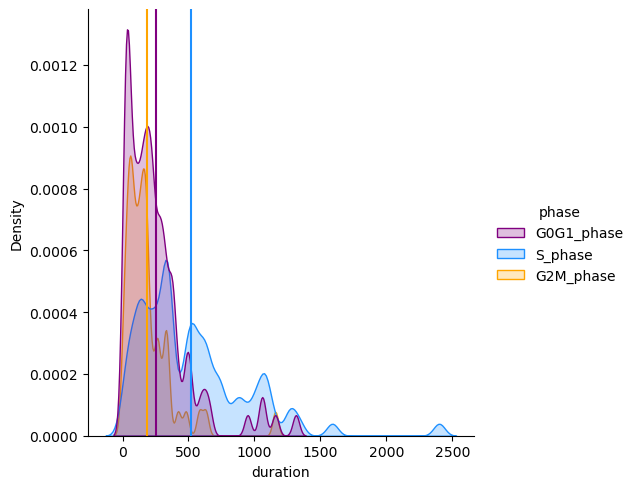

In [47]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

In [48]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_198223/543291753.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_198223/543291753.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_198223/543291753.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


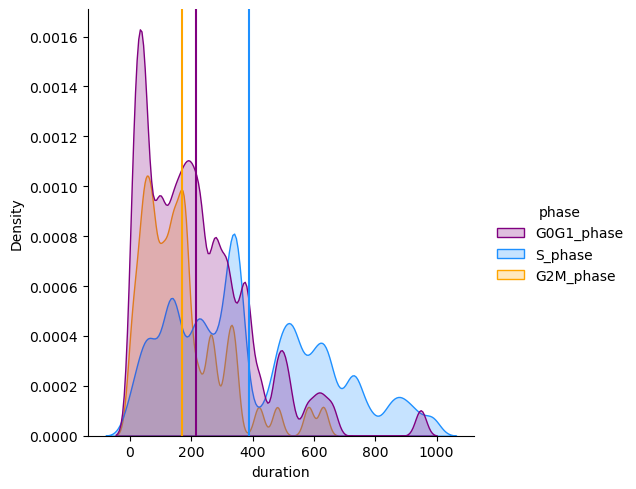

In [49]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

<AxesSubplot: xlabel='time_step', ylabel='counts'>

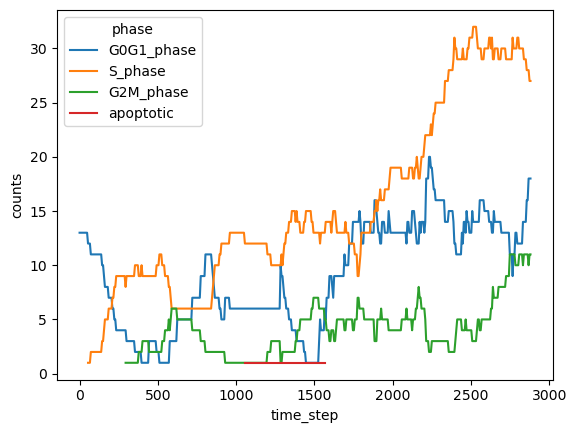

In [50]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

# Analysis of average duration of the whole cell cycle

In [51]:
data = full_data.groupby('time_step').agg({'phase':'count'})

Known initial number of cells (N0): 13
Estimated growth rate (r): 0.000502 per time unit (R2=0.967)
Average cell cycle duration: 23.01 hours


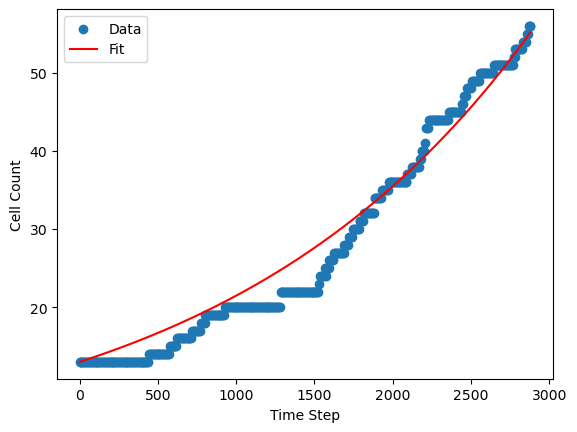

In [52]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

N0 = data["phase"][0]

# Exponential growth model
def exp_growth_model(t, r):
    return N0 * np.exp(r * t)

# Fit the model to the data
popt, pcov = curve_fit(exp_growth_model, data.index, data['phase'], p0=[0.01])

# Use the optimized parameters to calculate the fitted values
fitted_values = exp_growth_model(data.index, *popt)

# Calculate R^2 using the r2_score function from sklearn.metrics
R_squared = r2_score(data['phase'], fitted_values)

# Extract the fitted parameter (only r in this case)
r_fitted = popt[0]

# Calculate the average division time based on the fitted growth rate
average_division_time = np.log(2) / r_fitted

print(f"Known initial number of cells (N0): {N0}")
print(f"Estimated growth rate (r): {r_fitted:.4g} per time unit (R2={R_squared:.3f})")
# print(f"Average Division Time (cell cycle duration): {average_division_time} time units")
print(f"Average cell cycle duration: {(average_division_time/60):.2f} hours")
# print(R_squared)
# Plot the data and the fit
plt.scatter(data.index, data['phase'], label='Data')
plt.plot(data.index, exp_growth_model(data.index, r_fitted), label='Fit', color='red')
plt.xlabel('Time Step')
plt.ylabel('Cell Count')
plt.legend()
plt.show()

In [53]:
# Known values
desired_cell_cycle_duration_hours = 24  # hours
observed_average_cell_cycle_duration_hours = average_division_time/60 # hours
current_scaling_factor = 60

# Compute the correction factor
correction_factor = desired_cell_cycle_duration_hours / observed_average_cell_cycle_duration_hours

# Apply the correction factor to the current scaling factor
corrected_scaling_factor = current_scaling_factor * correction_factor

print(f"Correction Factor: {correction_factor}")
print(f"Corrected Scaling Factor: {corrected_scaling_factor}")

Correction Factor: 1.0428659889837313
Corrected Scaling Factor: 62.57195933902388


# PLK1 Knock-Out Analysis

In [54]:
path = "../../../../output_plk1_knockout"
xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [55]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/481 [00:00<?, ?it/s]

In [56]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

AVERAGE DURATION OF EACH CELL CYCLE PHASE


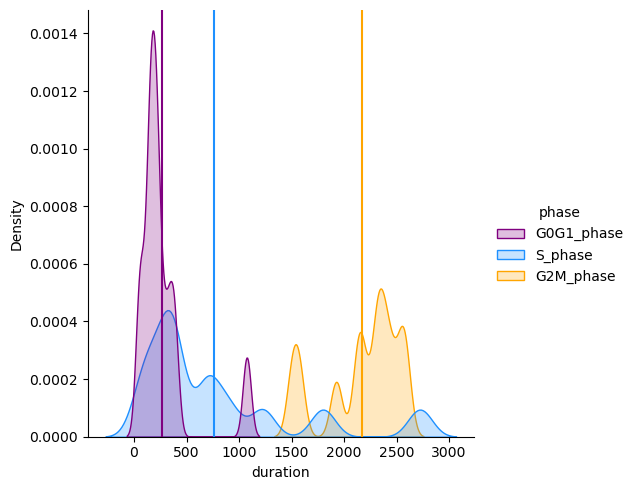

In [57]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_198223/3774474368.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
/tmp/ipykernel_198223/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


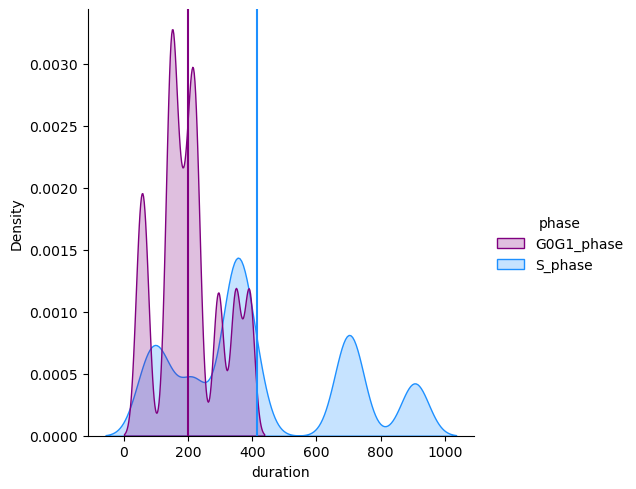

In [58]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

<AxesSubplot: xlabel='time_step', ylabel='phase'>

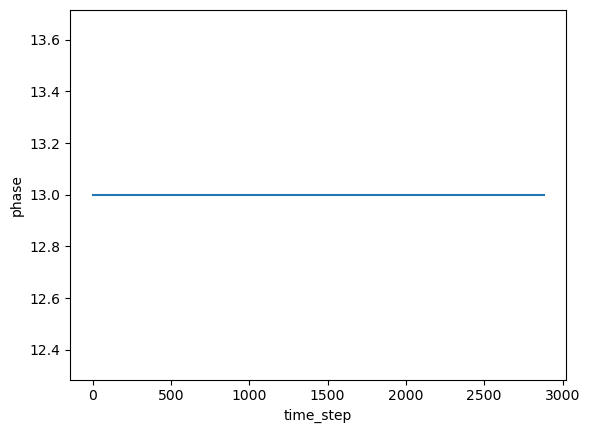

In [59]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot: xlabel='time_step', ylabel='counts'>

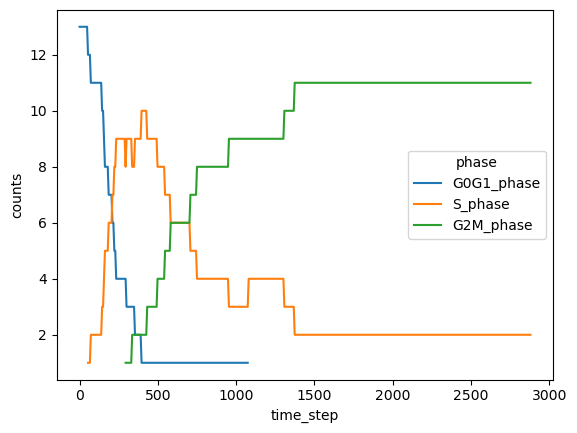

In [60]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

# FOXO3 KNOCK-OUT ANALYSIS

In [61]:
path = "../../../../output_foxo3_knockout/"
xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [62]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/481 [00:00<?, ?it/s]

In [63]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/24 [00:00<?, ?it/s]

AVERAGE DURATION OF EACH CELL CYCLE PHASE


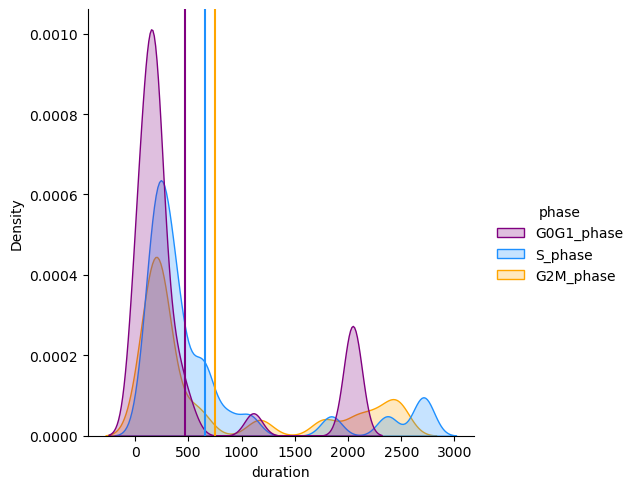

In [64]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_198223/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


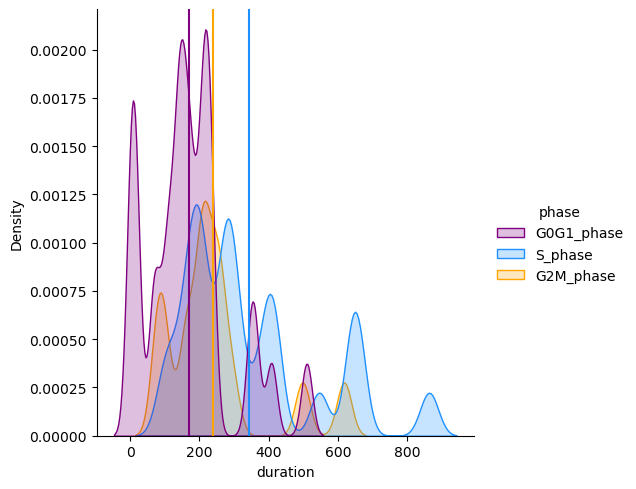

In [65]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


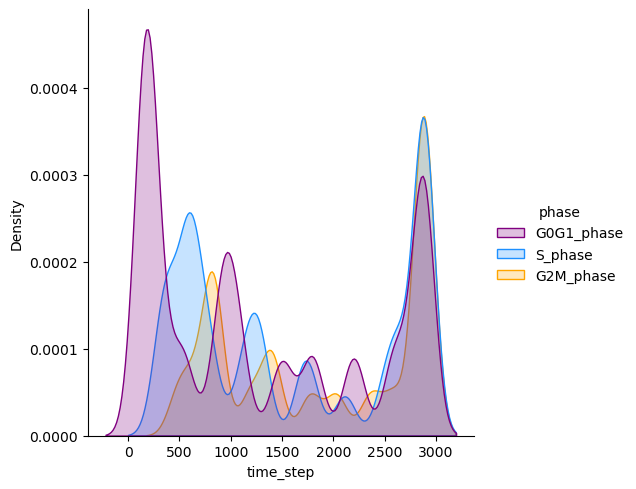

In [66]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

<AxesSubplot: xlabel='time_step', ylabel='phase'>

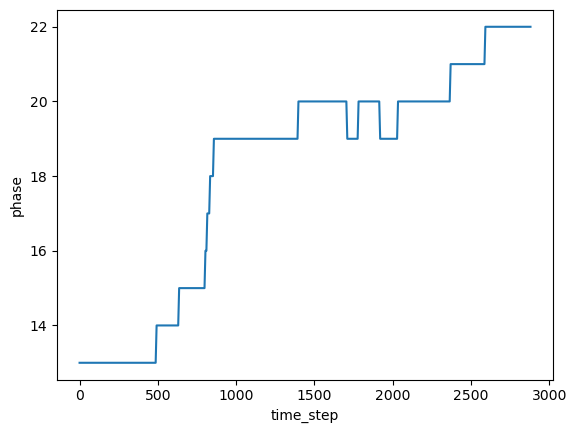

In [67]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot: xlabel='time_step', ylabel='counts'>

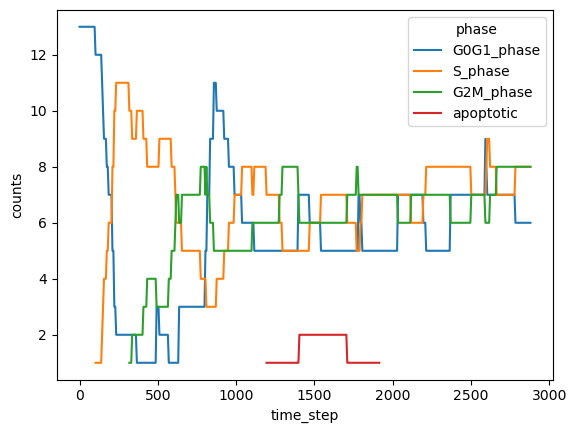

In [68]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

Average duration for each cell cycle phase, detail


<AxesSubplot: xlabel='phase', ylabel='duration'>

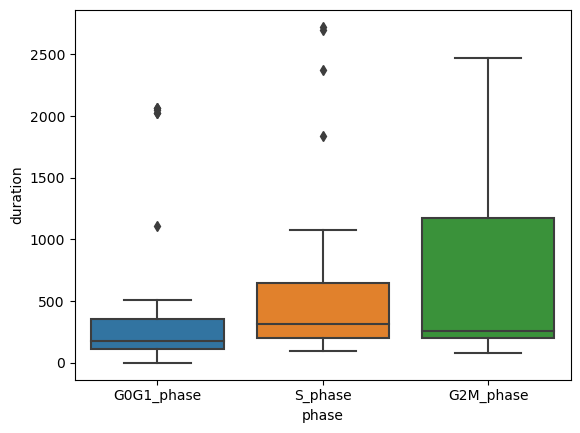

In [69]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")


# p110_H and PI3K_H KNOCK-IN ANALYSIS

In [70]:
path = "../../../../output_double_mutants"

xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [71]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/481 [00:00<?, ?it/s]

In [72]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/52 [00:00<?, ?it/s]

AVERAGE DURATION OF EACH CELL CYCLE PHASE


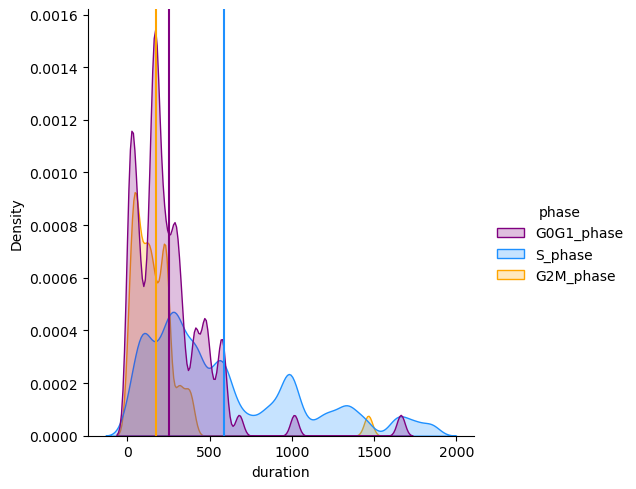

In [73]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_198223/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_198223/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


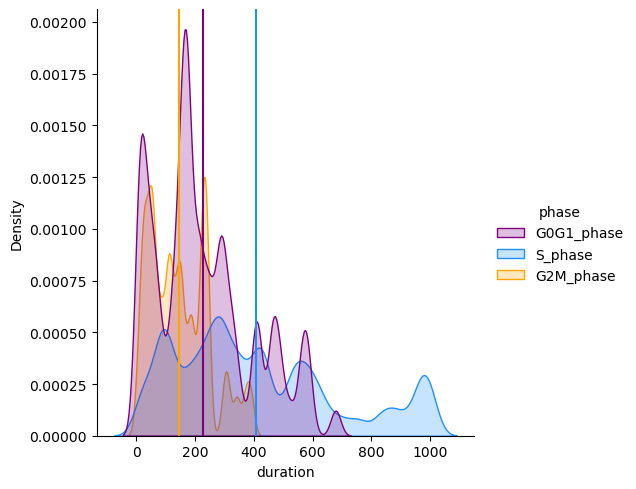

In [74]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION


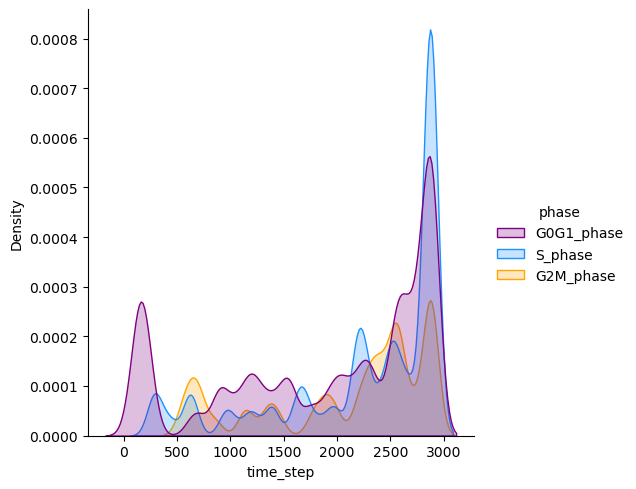

In [75]:
print("EVOLUTION OF THE CELL CYCLE DURING THE SIMULATION")
sb.displot(filtered_data, x="time_step", kind="kde", hue='phase', fill=True, bw_adjust=.20, palette=palette)

Average duration for each cell cycle phase, detail


<AxesSubplot: xlabel='phase', ylabel='duration'>

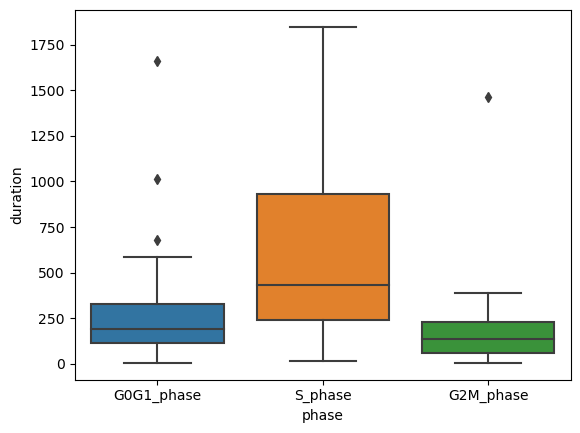

In [76]:
print("Average duration for each cell cycle phase, detail")
sb.boxplot(data=filtered_data, x='phase', y="duration")

<AxesSubplot: xlabel='time_step', ylabel='phase'>

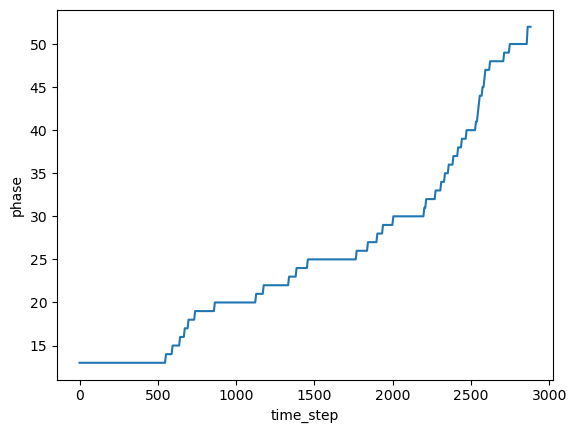

In [77]:
df1 = full_data.groupby('time_step').agg({'phase':'count'})

sb.lineplot(data=df1, x="time_step", y="phase")

<AxesSubplot: xlabel='time_step', ylabel='counts'>

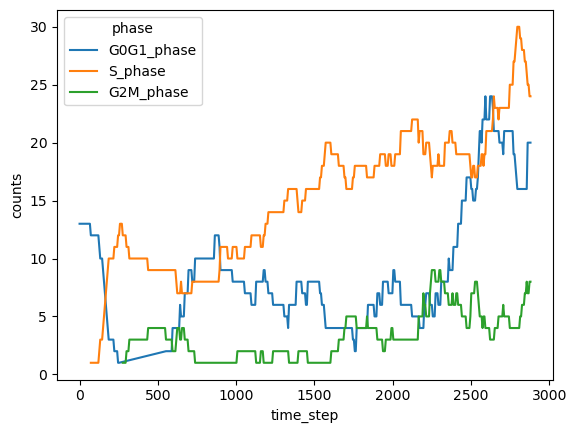

In [78]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")